### Advanced ML Projekt 

Dieses Projekt ist die Prüfungsleistung von Sophia Bühl aus dem Kurs WWI2020F im Kurs Advanced Applied Machine Learning. 

Alle genutzten Quellen sind direkt im Code angegeben, nach den neuen Zitierrichtlinien für Code der DHBW.

Die Begründung des Themas und die ethische Betrachtung finden nach der Datenanalyse statt.

Die Modelle sind alle gespeichert. Der Code kann so auskommentiert werden, dass er lauffähig ist.


Die Ausführzeit im aktuellen Zusatnd (Training des Neuronalen Netzes / SVM / XGBoost auskommentiert) beträgt 18 Minuten.

**Installationen**

In [257]:
! pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [258]:
# ! pip install scikit-image
# ! pip install opencv-python
# ! pip install webcolors
# ! pip install xgboost
# ! pip install tensorflow
# ! pip install tensorflow-gpu
# ! pip install Keras-Preprocessing
# ! pip install keras-metrics
# ! pip install imblearn
# ! pip install opendatasets

**Pakete importieren**

In [259]:
import pandas as pd
from PIL import Image
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import matplotlib.pyplot as plt  
import cv2
import webcolors
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import joblib

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from keras.utils import to_categorical, normalize
from keras import backend as K
from keras.optimizers import Adam

import time
import sys
import opendatasets as od

In [260]:
start_time_whole = time.time()

In [261]:
od.download("https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset")

 98%|█████████▊| 2.52G/2.58G [03:43<00:05, 12.5MB/s]

### Datenbetrachtung
Um die Daten besser zu verstehen und sie einschätzen zu können, werden sie im ersten Schritt betrachtet und grundlegend bereinigt. Dafür werden die Daten geladen und die Nullwerte anschließend entfernt. Nachfolgend werden die Spalten des DataFrames betrachtet und Abhängigkeiten und Verteilungen analysiert.

**Daten laden**

In [ ]:
# folder with images
image_folder = 'skin-cancer-dataset/Skin Cancer/Skin Cancer'

# filename of images
image_filenames = os.listdir(image_folder)


In [ ]:
# save matadata into DataFrame
df_metadata = pd.read_csv('skin-cancer-dataset/HAM10000_metadata.csv')
df_metadata.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# get columns with Null values and the Datatype
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


**Nullwerte entfernen** <br>

Nullwerte und unbekannte Werte werde aus dem Datensatz entfernt, um im Verlauf Modelle des maschinellen Lernens trainieren zu können und diese zudem interpretierbar zu machen.

In [ ]:
# drop Null values
df_metadata = df_metadata.dropna()

In [ ]:
# get the unique column values and count them
print(df_metadata['localization'].value_counts())

# drop unknown localizations
df_metadata = df_metadata.drop(df_metadata[df_metadata['localization'] == 'unknown'].index)

back               2192
lower extremity    2077
trunk              1403
upper extremity    1116
abdomen            1021
face                743
chest               405
foot                317
unknown             187
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


In [ ]:
# get the unique column values and count them
print(df_metadata['sex'].value_counts())

# drop unknown sex
df_metadata = df_metadata.drop(df_metadata[df_metadata['sex'] == 'unknown'].index)

male       5308
female     4453
unknown      10
Name: sex, dtype: int64


In [ ]:
# proof the results
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     9761 non-null   object 
 1   image_id      9761 non-null   object 
 2   dx            9761 non-null   object 
 3   dx_type       9761 non-null   object 
 4   age           9761 non-null   float64
 5   sex           9761 non-null   object 
 6   localization  9761 non-null   object 
dtypes: float64(1), object(6)
memory usage: 610.1+ KB


**Größe der Bilder bestimmen**<br>

Um einen ersten Überblick über die Bilder zu erhalten, wird hier die Größe bestimmt. Diese wird im Verlauf angepasst.

In [ ]:
# get the first image out of folder
first_image = os.path.join(image_folder, image_filenames[0])

# open the image
first_image = Image.open(first_image)

# get the size with width and height, print it
width, height = first_image.size
print('Breite:', width, 'Höhe:', height)

Breite: 600 Höhe: 450


**Arten des Hautkrebs**<br>

Da die Hautkrebsarten nicht jedem geläufig sind und das Verstehen zu einem besseren Verständnis der Daten und der Ergebnisse beiträgt, werden die im Datensatz vohandenen Hautkrebsarten kurz erklärt und auf die Altersgruppen, das Geschlecht und die häufigen Lokationen eingegangen. Mit diesem Vorwissen kann bei nachfolgenden Analysen überprüft werden, ob der ausgewählte Datensatz realitätsnah ist und eine übliche Verteilung aufzeigt.

Im Datensatz sind insgesamt sieben Hautkrebsarten vorhanden, die zusammen 9761 mal vertreten sind. Am häufigsten ist das Melanozytennävus (nv) im Datensatz. Dabei handelt es sich um gutartige Fehlbildungen, die meist bräunlich sind. Aus ihnen können Melanome (mel) entstehen. (Vgl. https://www.ukw.de/hautklinik/schwerpunkte/hauterkrankungen-im-kindesalter/melanozytaere-naevi/ 13.06.23) 

Melanome (schwarzer Hautkrebs) sind die gefährlichste Hautkrebsart. In Deutschland liegt das Risiko daran zu erkranken bei ungefähr 2%, die Zahl der Betroffenen steigt jährlich. Ursachen dafür sind Sonnenbrände, aber auch genetische Veranlagungen, wie der Hauttyp. Melanome sind dunkle Flecken. Männer sind etwas häufiger betroffen als Frauen. Bei Frauen treten sie zudem früher auf, während Männer erst im höheren Alter betroffen sind. Bei früher Erkennung können diese meist operativ entfernt werden, wodurch die Sterberate auch hier gering ist. (Vgl. https://www.krebsgesellschaft.de/onko-internetportal/basis-informationen-krebs/krebsarten/hautkrebs/malignes-melanom-schwarzer-hautkrebs.html 13.06.23)

Eine weitere gutartige Hautkrebsart sind die umgangssprachlich genannten Sonnenflecken (bkl). Sie entstehen, wenn UV-Strahlung Schäden an der Haut verursachen. Sie sind daher meist an Stellen zu finden, die häufig der Sonne ausgesetzt sind, wie im Gesicht, oder an den Händen. In Deutschland sind 80% der über 60-jährigen davon betroffen. (Vgl. https://deximed.de/home/klinische-themen/haut/krankheiten/pigmentierte-laesionen/lentigo-solaris#zusammenfassung 13.06.23) 

Neben dem schwarzen Hautkrebs gibt es auch hellen, bzw. weißen Hautkrebs. Darunter zählen Basalzellkarzinome (bcc). Sie sind meist im Kopf- und Halsbereich lokalisiert und machen etwa drei Viertel der Hauttumore aus, welche nicht zu den Melanomen zählen. 77% der Menschen in Deutschland, die an hellem Hautkrebs erkranken, sind von Basalzellkarzinome betroffen und machen damit den größten Teil aus. Die Sterberate ist bei weißem Hautkrebs sehr gering. (Vgl. https://www.krebsgesellschaft.de/onko-internetportal/basis-informationen-krebs/krebsarten/hautkrebs/basalzellkarzinom.html 13.06.23)

Ebenfalls zum weißen Hautkrebs zählen die Plattenepithelkarzinome (akiec). Neben den 77% der betroffenen Menschen, die an Basalzellkarzinome erkraken, machen sie 22% der Erkrankungen an weißem Hautkrebs in Deutschland aus. Ein Frühstadium ist die Form Morbus Bowen. Sie betrifft die äußerste Hautschicht und kann durch zu hohe UV-Belastung verursacht werden. Die betroffenen Stellen sind rötlich bis braun und oft schuppig. (Vgl. https://www.msdmanuals.com/de-de/heim/hauterkrankungen/hautkrebs/bowen-krankheit 13.06.23) 

Bei vaskulären Läsionen (vasc) handelt es sich um Fehlbildungen von Blutgefäßen und sind gutartig. Es gibt verschiedene Arten dieser Läsionen und sie kommen unterschiedlich oft vor. 

Die letzte Hautkrebsart im Datensatz sind Dermatofibrome (df), oder auch harte Fibrome genannt. Dabei handelt es sich um einen gutartigen Hauttumor, der meist an den Extremitäten und am Rumpf auftritt. Der Tumor tritt häufig bei jüngeren Menschen auf und Männer sind weniger häufig von Dermatofibromen betroffen als Frauen. (Vgl. https://www.ncbi.nlm.nih.gov/books/NBK470538/ 13.06.23)

Insgesamt sind Männder häufiger von Hautkrebs betroffen als Frauen. Frauen erkranken zudem früher an Hauttumoren, als Männer.

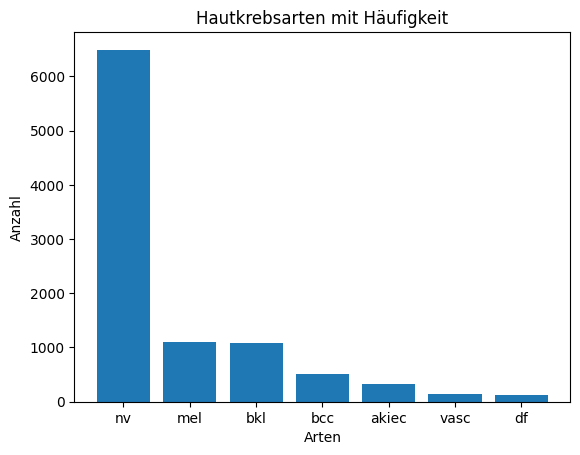

In [ ]:
# get unique values with count from column
values, counts = np.unique(df_metadata['dx'], return_counts=True)

# values and counts into a list of tuples
tupel_list = list(zip(values, counts))

# sort the list descending
tupel_list_sorted = sorted(tupel_list, key=lambda x: x[1], reverse=True)

# separate as extra lists
values, counts = zip(*tupel_list_sorted)

# bar plot
plt.bar(values, counts)

# title x and y
plt.xlabel('Arten')
plt.ylabel('Anzahl')
plt.title('Hautkrebsarten mit Häufigkeit')

plt.show()

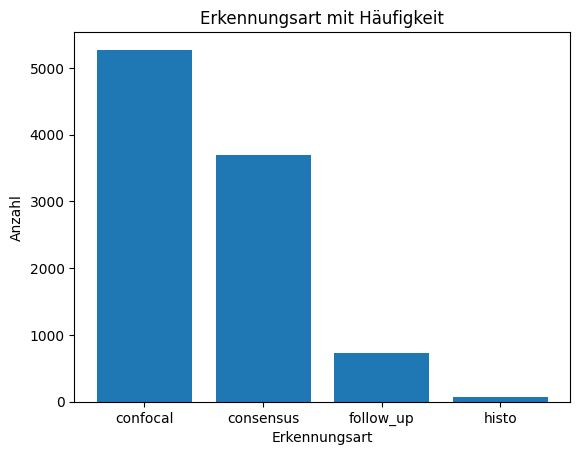

In [ ]:
# get unique values with count from column
values, counts = np.unique(df_metadata['dx_type'], return_counts=True)

# sort it with descending order
counts = np.sort(counts)[::-1]

# bar plot
plt.bar(values, counts)

# title x and y
plt.xlabel('Erkennungsart')
plt.ylabel('Anzahl')
plt.title('Erkennungsart mit Häufigkeit')

plt.show()

**Betroffene Altersgruppen**<br>

Um zu überprüfen, ob der Datensatz den Erwartungen entspricht, welche Altersgruppen am häufigsten betroffen sind und damit ein realistisches Bild vermittelt, werden sich im nächsten Schritt die betroffenen Altersgruppen und das Alter im Zusammenhang mit dem Geschlecht betrachtet. 

Im dargestellten Säulendiagramm ist erwartungsgemäß zu erkennen, dass viele der Hautkrebserkrankungen ab 40 Jahren diagnostiziert werden und im höheren Alter mehr Menschen von Hautkrebs betroffen sind. Junge Menschen erkranken hingegen wesentlich seltener an Hautkrebs.

In der Pivot-Tabelle ist erwartungsgemäß zu sehen, dass viele der jungen Menschen ein harmloses Melanozytennävus besitzen, oder an Fehlbildungen von Blutgefäßen leiden. Auffällig ist, dass Plattenepithelkarzinome erst bei älteren Menschen ab 40 diagnostiziert werden. Dies kann daran liegen, dass diese Art des Hautkrebses durch UV-Strahlung entstehen kann und damit erst später auftritt. 

Melanome treten in den Daten erstaunlich oft bereits ab 20 Jahren häufiger auf. Dies passt aber zu der Annahme, dass die Zahl der Melanome steigt und auch jüngere Menschen bereits davon betroffen sind. 

Die Altersgruppe der Dermatofibrome entspricht ebenfalls den Erwartungen und zeigt eine realistische Verteilung, da diese Hautkrebsart vermehrt im mittleren Alter zwischen 35 und 65 Jahren auftritt und weniger bei älteren Menschen.

Eine unerwartete Anzahl an sehr jungen betroffenen Menschen tritt bei den Sonnenflecken auf. 

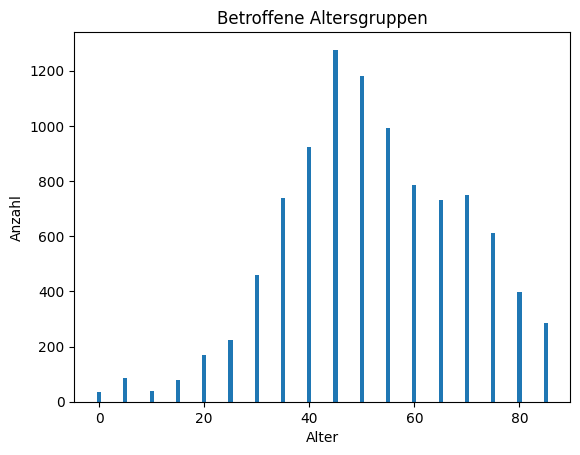

In [ ]:
# count the values
counts = df_metadata['age'].value_counts()

# ages as index
values = counts.index

# bar plot
plt.bar(values, counts)

# title x and y
plt.xlabel('Alter')
plt.ylabel('Anzahl')
plt.title('Betroffene Altersgruppen')

plt.show()

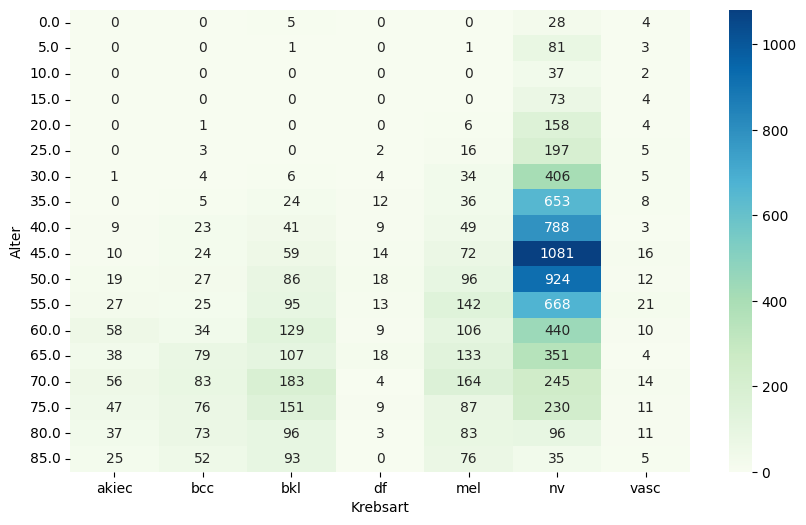

In [ ]:
# pivot table wigh the age and the cncer type
pivot_table = df_metadata.pivot_table(index='age', columns='dx', aggfunc='size', fill_value=0)

# size of the plot
plt.figure(figsize=(10, 6))

# heatmap with the color
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='GnBu')

# label x and y
plt.xlabel('Krebsart')
plt.ylabel('Alter')

plt.show()

**Betroffene Geschlechter**<br>

Im vorliegenden Datensatz sind insgesamt mehr Männer als Frauen vorhanden, die von Hautkrebs betroffen sind. Die stimmt mit den aktuellen Statistiken überein. Zudem ist zu erkennen, dass Frauen zwischen 30 und 60 Jahren die Diagnose erhalten, während die Zeitspanne bei Männern etwas später bei 35 beginnt, aber bis 80 Jahre geht. In diesen Zeiträumen werden die meisten Hautkrebs-Diagnosen gestellt.

In [ ]:
# count the unique values
df_metadata['sex'].value_counts()

male      5308
female    4453
Name: sex, dtype: int64

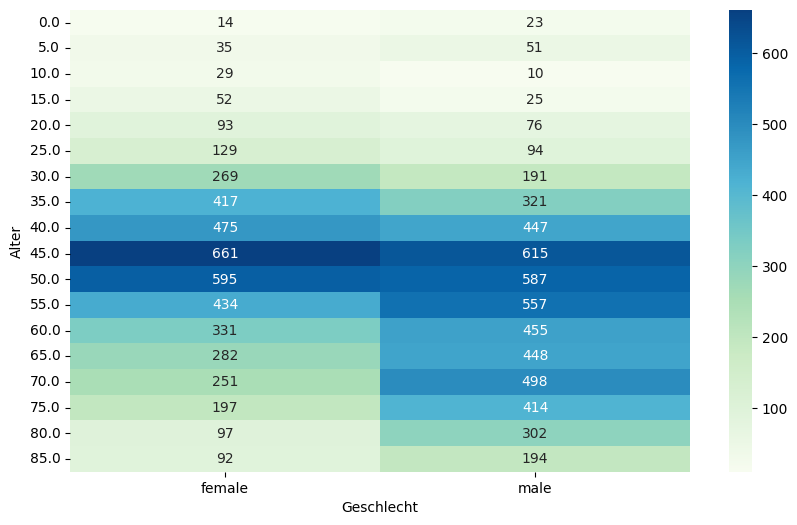

In [ ]:
# pivot table witg the age and sex
pivot_table = df_metadata.pivot_table(index='age', columns='sex', aggfunc='size', fill_value=0)

# size of the figure
plt.figure(figsize=(10, 6))

# heatmap with the color
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='GnBu')

# label x and y
plt.xlabel('Geschlecht')
plt.ylabel('Alter')

plt.show()

**Betroffene Körperregionen**<br>

Die Extrimitäten und der Rücken, zusammen mit dem Rumpf, sind die Körperregionen, an denen Hautkrebs besonders häufig auftritt. Dies ist mit der dort häufig auftertenden UV-Belastung zu erklären. Zudem sind der Rücken und der Rumpf große Körperregionen, wodurch die Häufigkeit hier steigt. 

In der Pivot-Tabelle ist deutlich zu erkennen, dass diese Körperregionen von nahezu allen Krebsarten betroffen sein können und weitestegehend von den Hautkrebsarten, die bei zu hoher UV-Belastung entstehen.

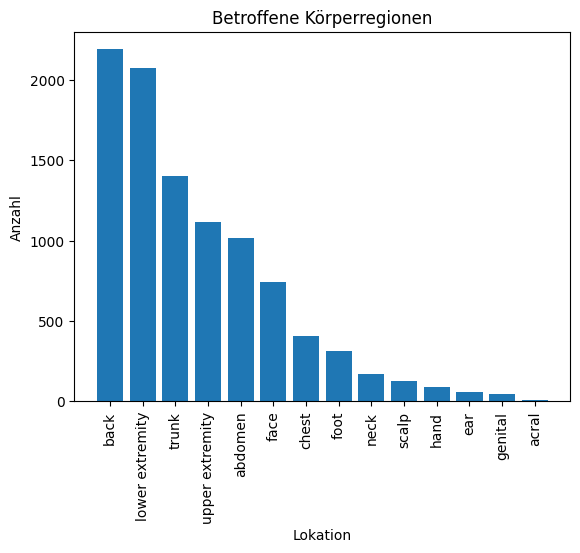

In [ ]:
# count the values
counts = df_metadata['localization'].value_counts()

# values as index
values = counts.index

# bar plot
plt.bar(values, counts)

# title x and y
plt.xlabel('Lokation')
plt.ylabel('Anzahl')
plt.title('Betroffene Körperregionen')

# rotate the labels on x
plt.xticks(rotation=90)

plt.show()

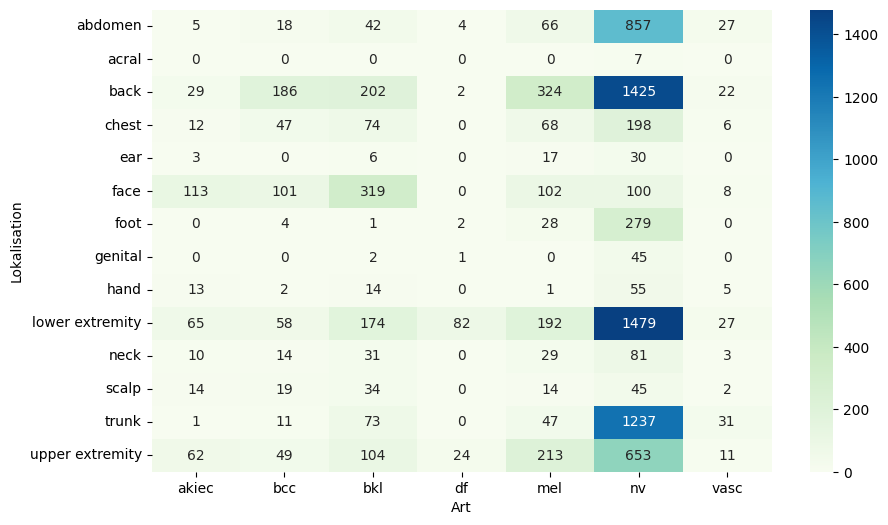

In [ ]:
# pivot tabel with localization and cancer type
pivot_table = df_metadata.pivot_table(index='localization', columns='dx', aggfunc='size', fill_value=0)

# define figure size
plt.figure(figsize=(10, 6))

# heatmap with the color
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='GnBu')

# label x and y
plt.xlabel('Art')
plt.ylabel('Lokalisation')

plt.show()

### Relevanz der Daten und resultierende Fragestellung
Nach der Datenbetrachtung wurde sich dafür entschieden den Datensatz zu nutzen, da hierbei ein relevantes Thema behandelt wird. Das Thema ist sehr relevant, da die Anzahl der Hautkrebs-Diagnosen in Deutschland und weltweit immer weiter steigt. 2021 wurden in Deutschland über 100.000 Menschen stationär im Krankenhaus wegen Hautkrebs behandelt. Das sind fast 75% mehr, als noch im Jahr 2001 (Vgl. https://www.destatis.de/DE/Presse/Pressemitteilungen/Zahl-der-Woche/2023/PD23_21_p002.html 23.05.23). Ein möglicher Grund dafür ist der Klimawandel und die damit verbundenen erhöhten UV-Strahlen. Aufgrund der aktuellen Thematik und den erhöhten Diagnosezahlen, auch für schwarzen Hautkrebs, ist das Thema für die Zukunft sehr relevant.

Eine frühe Erkennung von Hautkrebs ist dabei wichtig. Hautkrebs ist bei früher Erkennung gut behandelbar. Viele Krankenkassen bieten deshalb auch ein Hautscreening an. Wurde eine auffällige Stelle gefunden, bei der es sich um Hautkrebs handelt, muss dieser zunächst klassifiziert werden.

Die Fragestellung dieses Projekts lautet daher: Mit welcher machine learning Methode lassen sich Hautkrebsarten anhand Bilder mit zusätzlichen Informationen am genausten und effizientesten klassifizieren?

Der ausgewählte Datensatz (https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset 23.05.23) unterscheidet sich von den gängigen Datensätzen in der Hautkrebs-Klassifizierung, da er bereits einige zusätzliche Metadaten, wie das Geschlecht und das Alter der Patienten enthält. Diese Metadaten werden im Projekt berücksichtigt und in die Analyse und die Klassifizierung als zusätzliche Features mit einbezogen.

Der Datensatz kann von Kaggle heruntergeladen werden, oder über die Kaggle-API genutzt werden. Die zusätzlichen Features, wie die Form und die Farbe des Hautkrebs, werden durch den Code erstellt und hinzugefügt.

Im folgenden Code werden die Daten vorbereitet und zusätzliche Features extrahiert. Anschließend werden drei Methoden verglichen, wie der Hautkrebs klassifiziert werden kann.

### Kritische Betrachtung und moralische Aspekte

Der Datensatz ist aufgrund mehrerer Aspekte kritisch zu betrachten. Die erste Auffälligkeit ist, dass die Hautfarbe der Personen auf den Bildern in den Daten ausschließlich hell ist. Dunkle Hautfarben werden nicht beachtet und damit ausgeschlossen. Selbst wenn das Modell nicht explizit die Hautfarbe beachtet und die Hautkrebsarten bei hellen Hautfarben sehr gut klassfizieren kann, ist nicht gewährleistet, dass das selbe Modell auch die Hautkrebstypen bei Menschen mit dunkler Hautfarbe richtig klassifizieren kann. Dies wäre jedoch wichtig, da jeder Mensch Hautkrebs entwickeln kann, unabhängig der Hautfarbe (Vgl. https://www.skincancer.org/skin-cancer-information/skin-cancer-skin-of-color/ 15.06.23). Durch die braune Färbung der Melanome und dem unterschiedlichen Aussehen der Melanome im Vergleich zu hellen Hauttypen, wird der Hautkrebs oft später etdeckt. Bei Hautkrebs ist eine schnelle Identifikation und Behandlung jedoch entscheidend, um ihn gut behandeln zu können (Vgl. https://www.medicalnewstoday.com/articles/skin-cancer-black-skin#diagnosis 15.06.23).

Um diesen moralischen Aspekt zu lösen, könnte ein zweites Modell auf Daten mit dunklen Hauttypen trainiert werden. Das gleiche Modell zu verwenden und es anzupassen wird aufgrund des unterschiedlichen Aussehens der Melanome als nicht sinnvoll erachtet. Mit dem zweiten Modell könnten dann auch Hautkrebstypen bei Menschen mit dunkler Hautfarbe klassifiziert werden.

Eine weitere kritische Betrachtung bedarf der Geschlechterverteilung. Die erste Sorge, dass es hier ein signifikantes Ungleichgewicht geben könnte, wurde durch die erste Aalyse der Daten genommen. Es gibt zwar etwas mehr Daten von männlichen Patienten, dies entspricht jedoch der Verteilung in den gängigen Statistiken, dass Männer etwas häufiger von Hautkrebs betroffen sind und bildet die Situation realitätsnah ab.

Nach der Analyse lässt sich feststellen, dass die Daten, abgesehen von der Hautfarbe, repräsentatv sind. Die Verteilung der Altersgruppen und der Geschlechter, zusammen mit den Krebsarten und den Lokationen, bilden die Realität gut ab.

### Vorbereitung der Bilder
Für die Vorverarbeitung der Bilder werden diese zunächst in eine quadratische Form gebracht und in einem separaten Ordner gespeichert. Um das Ergebnis zu überprüfen wird das erste Bild aus dem neuen Ordner entnommen und ausgegeben, um die Form zu kontrollieren.

In [ ]:
# new folder for the resized images
resized_folder = 'archive/Skin-Cancer/Skin-Cancer-Resized'

# create the folder, if the path does not exist yet
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

**Bildgröße ändern**<br>

Um die Größe der Bilder zu verändern wurde folgende Dokumentation genutzt.

***
Der folgende Code basiert auf [Geeks for Geeks: Python PIL | Image.resize() method] (https://www.geeksforgeeks.org/python-pil-image-resize-method/)

author: Sunitamamgai<br>
published on: 31.03.23<br>
title: Python PIL | Image.resize() method<br>
accessed: 08.06.23

In [ ]:
# create list to store image arrays
images = []

# list of filenames in folder
image_filenames = os.listdir(image_folder)

for file in image_filenames:

    # path to image file
    image_path = os.path.join(image_folder, file)

    # path to resized image file
    resized_path = os.path.join(resized_folder, file)

    # open image
    image = Image.open(image_path)

    # rezise the images as square ans save them
    resized_image = image.resize((244, 244))
    resized_image.save(resized_path)

    # convert images into numpy array and add them to list
    image_array = np.array(resized_image)
    images.append(image_array)

# convert list to numpy arrays
images_array = np.array(images)

# list of filenames of resized image folder
image_filenames_resized = os.listdir(resized_folder)

**Beispielbild zur Überprüfung - Bildgröße**

Um die Ergebnisse zu überprüfen und nachvollziehbar zu machen wird im Code in mehreren Schritten ein Beispielbild gezeigt. Dies diente auch während dem Programmieren zum Überprüfen der Ergebnisse.

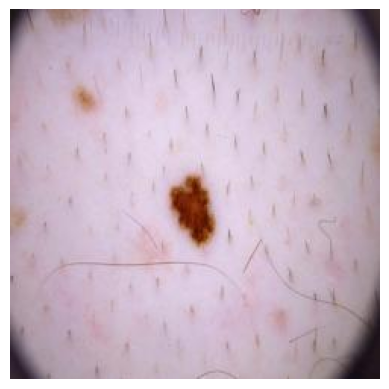

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=244x244 at 0x2983CB490>


In [ ]:
# if the folder path exists
if os.path.exists(resized_folder):

    # get list of image files in folder
    image_files = os.listdir(resized_folder)
    
    # if there are images in the folder
    if image_files:

        # get the first image
        first_image_path = os.path.join(resized_folder, image_files[0])

        # open the image
        image = Image.open(first_image_path)
        
        # plot the image without axes
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# print the image object for informations 
print(image)

**Umrisse des Melanoms als Feature**<br>

Nachfolgend werden Funktionen definiert, um den Umriss des jeweiligen Melanoms auf den Bildern zu extrahieren und als extra Feature zu speichern. Um den Prozess nachvollziehen zu können wird ein beispielhaftes Melanom genutzt und daran die Schritte erklärt.

Die Feature-Extraktion wird manuell mithilfe der OpenCV durchgeführt, um die Schritte nachzuvollziehen und zu verstehen. Es stellt zudem sicher, dass das gewünschte Ergebnis erzielt wird.

Für die Feature-Extraktion der Form des Hautkrebs wurde sich zur Kantenerkennung an dem Vorgehen von den folgenden zwei Quellen orientiert.

***
Der folgende Code basiert auf [Medium: Canny Edge Detection Step by Step in Python — Computer Vision] (https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

author: Sofiane Sahir<br>
published on: 25.01.19<br>
title: Canny Edge Detection Step by Step in Python — Computer Vision<br>
accessed: 13.06.23

[LearnOpenCV: Edge Detection Using OpenCV] (https://learnopencv.com/edge-detection-using-opencv/)

title: Edge Detection Using OpenCV<br>
accessed: 13.06.23
***

Für die konvexe Hülle der Ellipse und die anschließende Farberkennung wurden folgende Quellen benutzt.

***
Der folgende Code basiert auf [TutorialsPoint: How to fit the ellipse to an object in an image using OpenCV Python?] (https://www.tutorialspoint.com/how-to-fit-the-ellipse-to-an-object-in-an-image-using-opencv-python)

author: Shahid Akhtar Khan<br>
published on: 28.09.22<br>
title: How to fit the ellipse to an object in an image using OpenCV Python?<br>
accessed: 12.06.23

[OpenCV: Contours : Getting Started] (https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html )

title: Contours : Getting Started<br>
accessed: 13.06.23
***

In der Funktion preprocess_images(img) können für einzelne Bilder die print Statements einkommentiert werden, um die einzelnene Schritte nachzuvollziehen und die Zwischenergenisse zu betrachten. 

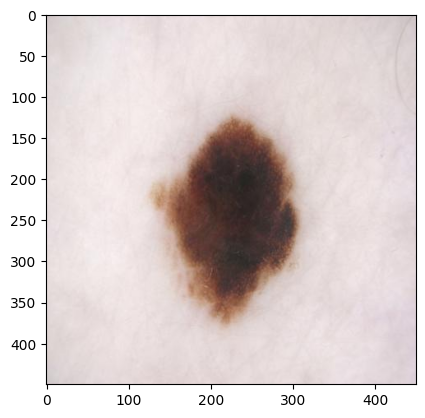

In [ ]:
# read the image file with the example image in BGR color
img = cv2.imread('ISIC_0034317.jpg', cv2.IMREAD_COLOR)

# change the color from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image and plot it
plt.imshow(img_rgb)
plt.show()

In [ ]:
def rgb2gray(rgb):
    """
    Convert RGB image to grayscale

    Args:
        rgb (ndarray): RGB image

    Returns:
        ndarray: Grayscale image
    """

    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123 and https://learnopencv.com/edge-detection-using-opencv/ were used

def preprocess_images(img):
    """
    Preprocesses the images to get edges and draw a green convex hull around the contours of the melanoma

    Args:
        img (ndarray): resized image

    Returns:
        result (ndarray): resulting image with the green convex hull around the contours
        external_contour (ndarray): external contours of the edges
        convex_hull (ndarray): convex hull of the external contours
    """

    # put image into grayscale and scale it between 0 and 1
    gray = rgb2gray(img)    
    gray_scaled = (gray / 255.0)
    #plt.imshow(gray_scaled, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #plt.show()

    # reduce noise with GaussianBlur
    blurred = cv2.GaussianBlur(gray_scaled, (5, 5), 0)
    #plt.imshow(blurred, cmap='gray')
    #plt.show()

    # calculate edges with Sobel
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    sobelx = np.abs(sobelx)
    sobely = np.abs(sobely)

    # scale the sobel picture 
    sobel_combined = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)
    sobel_combined = (sobel_combined * 255).astype(np.uint8)
    #plt.imshow(sobel_combined, cmap='gray')
    #plt.show()

    # detect edges with Canny edge detection
    suppressed_edges = cv2.Canny(sobel_combined, 70, 150)
    #plt.imshow(suppressed_edges, cmap='gray')
    #plt.show()

    lower_threshold = 100
    upper_threshold = 200

    # get better edges with a second Canny edge detection on suppressed edges
    edges = cv2.Canny(suppressed_edges, lower_threshold, upper_threshold)
    #plt.imshow(edges, cmap='gray')
    #plt.show()

    # extrct contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # if there is one contour
    if len(contours) > 0:

        # calculate the convex hull
        external_contour = np.concatenate(contours)
        convex_hull = cv2.convexHull(external_contour)
        mask = np.zeros_like(img)

        # print the contours as green line on image 
        cv2.drawContours(mask, [convex_hull], -1, (0, 255, 0), thickness=2)

        # resukt image with the green convex hull
        result = cv2.bitwise_or(img, mask)

    else:
        
        # if there is no contour, it is just a black image
        external_contour = None
        convex_hull = None
        result = np.zeros_like(image)

    return result, external_contour, convex_hull

In [ ]:
# https://www.tutorialspoint.com/how-to-fit-the-ellipse-to-an-object-in-an-image-using-opencv-python was used

def calculate_eccentricity(external_contour):
    """
    Calculates the eccentricity of an external contour if it has at least 5 points
    - Value 0 for eccentricity means a perfect cicle
    - Value 1 is the largest deviation of a perfect cicle

    Args:
        external_contour (ndarray): external contour to calculate the eccentricity

    Returns:
        eccentricity (float/None): calculated eccentricity of the contour/None if contour has less than five points
    """

    # if contour has more than five points
    if len(external_contour) >= 5:

        # fit ellipse over contour
        ellipse = cv2.fitEllipse(external_contour)

        # get ellipse parameters
        (center, axes, angle) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)

        # calculate eccentricity
        eccentricity = np.sqrt(1 - (minor_axis / major_axis)**2)
        eccentricity = round(eccentricity, 4)
    
    else:
        eccentricity = None

    return eccentricity

In [ ]:
# https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html was used

def extract_color(convex_hull, img_rgb):
    """
    Extracts color in the convex hull of the image

    Parameters:
        convex_hull (ndarray): convex hull contour
        img_rgb (ndarray): input image in RGB

    Returns:
        hex_code (str): color represented as a hex-code
        melanoma_hull (ndarray): region of with only the melanoma-pixels.
    """
    
    # create mask with the shape of the image
    mask = np.zeros_like(img_rgb)

    # draw the convex hull on the mask
    cv2.drawContours(mask, [convex_hull], 0, (255, 255, 255), -1)

    # extraxt region in the convex hull
    melanoma_hull = cv2.bitwise_and(img_rgb, mask)

    # get indices of the melanoma pixels
    melanoma_pixels = np.where(np.all(melanoma_hull != [0, 0, 0], axis=-1))

    # get the average color of the melanoma
    color_avg = np.mean(img_rgb[melanoma_pixels], axis=0)

    # convert colors to integers
    color_avg = np.round(color_avg).astype(int)

    # convert colors to hex-code
    hex_code = webcolors.rgb_to_hex(color_avg)

    return hex_code, melanoma_hull

**Beispielbild zur Überprüfung - konvexe Hülle**

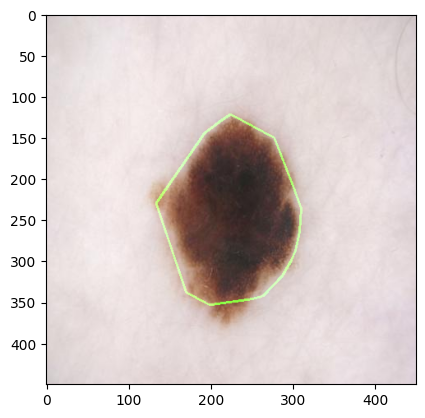

0.6416


In [ ]:
# preprocess one example image
result, external_contour, convex_hull = preprocess_images(img_rgb)

# show the preprocessed image
plt.imshow(result, cmap='gray')
plt.show()

# print calculated eccentricity
eccentricity = calculate_eccentricity(convex_hull)
print(eccentricity)

**Beispielbild zur Überprüfung - Farbe**

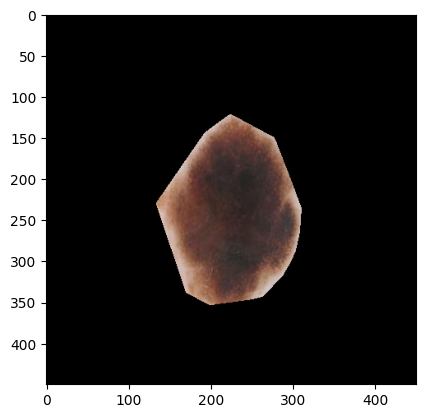

#6d4f46


In [ ]:
# extract color from one example image
hex_code, melanoma_hull = extract_color(convex_hull, img_rgb)

# show the preprocessed image
plt.imshow(melanoma_hull)
plt.show()

print(hex_code)

**Form und Farbe zur Tabelle hinzufügen**

In [ ]:
# initialize new columns for form and color in the metadata df
df_metadata['form'] = np.nan
df_metadata['color'] = np.nan

# iterate over images
for file in os.listdir(image_folder): #resized_folder

    # path to the image
    image_path_resized = os.path.join(image_folder, file) #resized_folder
    img_feature = cv2.imread(image_path_resized)

    # preprocessing of the images
    result, external_contour, convex_hull = preprocess_images(img_feature)

    # if there is a convex hull
    if convex_hull is not None:

        # calculate eccentricity (if it is a perfect circle or not)
        eccentricity = calculate_eccentricity(convex_hull)
        image_id = os.path.splitext(file)[0]

        # ad the form informations into the table
        df_metadata.loc[df_metadata['image_id'] == image_id, 'form'] = eccentricity

        # extract the color from the melanom
        color_avg, melanoma_hull = extract_color(convex_hull, img_rgb)

        # add the color infromations into the table
        df_metadata.loc[df_metadata['image_id'] == image_id, 'color'] = color_avg

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
[ WARN:0@59665.199] global loadsave.cpp:244 findDecoder imread_('skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0026322.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

### Vorverarbeitung der Metadaten

**Spalten und Reihen entfernen**

In [ ]:
# copy the dataframe
df_metadata_drop = df_metadata.copy()

# drop the image id and the lesion id
df_metadata_drop = df_metadata.drop(['lesion_id', 'image_id'], axis=1)

df_metadata_drop.head()

,dx,dx_type,age,sex,localization,form,color
0,bkl,histo,80.0,male,scalp,0.7104,#cfbfbd
1,bkl,histo,80.0,male,scalp,0.6435,#cebebc
2,bkl,histo,80.0,male,scalp,0.6882,#d3c4c3
3,bkl,histo,80.0,male,scalp,0.6154,#d0c0be
4,bkl,histo,75.0,male,ear,0.7436,#c9b8b6


**Label-Encoding der Features**

In [ ]:
# initialize the label encoder
label_encoder = LabelEncoder()

# define the columns to encode
encoding_columns = ['dx', 'dx_type', 'sex', 'localization', 'color']

# copy the dataframe
df_metadata_encoded = df_metadata_drop.copy()

for i in encoding_columns:

    # encode the values in the defined columns
    df_metadata_encoded[i] = label_encoder.fit_transform(df_metadata_drop[i])

print(df_metadata_encoded.head())

   dx  dx_type   age  sex  localization    form  color
0   2        3  80.0    1            11  0.7104   1003
1   2        3  80.0    1            11  0.6435    989
2   2        3  80.0    1            11  0.6882   1048
3   2        3  80.0    1            11  0.6154   1013
4   2        3  75.0    1             4  0.7436    918


In [ ]:
# initialize the label encoder for neuronal network
label_encoder2 = LabelEncoder()

# define the columns to encode
encoding_columns2 = ['dx', 'dx_type', 'sex', 'localization', 'color']

# copy the dataframe
df_metadata_encoded2 = df_metadata.copy()

df_metadata_encoded2 = df_metadata_encoded2.drop(['lesion_id'], axis=1)

for i in encoding_columns2:

    # encode the values in the defined columns
    df_metadata_encoded2[i] = label_encoder.fit_transform(df_metadata_drop[i])

print(df_metadata_encoded2.head())

       image_id  dx  dx_type   age  sex  localization    form  color
0  ISIC_0027419   2        3  80.0    1            11  0.7104   1003
1  ISIC_0025030   2        3  80.0    1            11  0.6435    989
2  ISIC_0026769   2        3  80.0    1            11  0.6882   1048
3  ISIC_0025661   2        3  80.0    1            11  0.6154   1013
4  ISIC_0031633   2        3  75.0    1             4  0.7436    918


In [ ]:
# drop null values
df_metadata_encoded2 = df_metadata_encoded2.dropna()

In [ ]:
# drop null values
df_metadata_encoded = df_metadata_encoded.dropna()
df_metadata_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9740 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dx            9740 non-null   int64  
 1   dx_type       9740 non-null   int64  
 2   age           9740 non-null   float64
 3   sex           9740 non-null   int64  
 4   localization  9740 non-null   int64  
 5   form          9740 non-null   float64
 6   color         9740 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 608.8 KB


### Vorbereitung der Bilder und Feature für Neuronales Netz
Bevor die Daten für das Neuronale Netz genutzt werden können, müssen sie zunächst angepasst werden.

In [ ]:
# define empty lists for the images and the features
image_list = []
feature_list = []

In [ ]:
# iterate over the encoded dataframe
for i, r in df_metadata_encoded2.iterrows():
    
    # extract the columns from the dataframe
    id = r['image_id']
    type = r['dx_type']
    age = r['age']
    sex = r['sex']
    localization = r['localization']
    form = r['form']
    color = r['color']

    # path to image
    path = os.path.join(image_folder, f"{id}.jpg")

    # read image
    image = cv2.imread(path)

    # resize image
    image = cv2.resize(image, (244, 244))

    # normalize image
    image = image.astype(np.float32) / 255.0

    # define the features
    features = [type, age, sex, localization, form, color]

    # append images and features to the two lists
    image_list.append(image)
    feature_list.append(features)

**Feature und Bilder als Numpy Array**

In [ ]:
# numpy array of the images
image_list = np.array(image_list)

In [ ]:
# numpy array of the features
feature_list = np.array(feature_list)

In [ ]:
# proof if the shapes are right
print("Shape of images array:", image_list.shape)
print("Shape of features array:", feature_list.shape)

Shape of images array: (9740, 244, 244, 3)
Shape of features array: (9740, 6)


**Label encoden**

In [ ]:
# define the encoded labels
labels_encoded = df_metadata_encoded['dx']
print(labels_encoded.shape)

(9740,)


### Neuronales Netz Klassifikation

**Train-Test-Split**

In [ ]:
# train-test-validation split with random state
X_train_img, X_test_img, X_train_feat, X_test_feat, y_train_nn, y_test_nn = train_test_split(image_list, feature_list, labels_encoded, test_size=0.2, random_state=42)
X_train_img, X_val_img, X_train_feat, X_val_feat, y_train_nn, y_val_nn = train_test_split(X_train_img, X_train_feat, y_train_nn, test_size=0.2, random_state=42)

In [ ]:
# values as categorial values
y_train_nn = to_categorical(y_train_nn)
y_val_nn = to_categorical(y_val_nn)
y_test_nn = to_categorical(y_test_nn)

In [ ]:
# proof if the shape is right
print(X_train_img.shape)
print(y_train_nn.shape)

(6233, 244, 244, 3)
(6233, 7)


**Definiere F1-Metrik**<br>

Der folgende Code basiert auf [Medium: How to add function (Get F1-score) in Keras metrics and record F1 value after each epoch?] (https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)

author: Aakash Goel<br>
published on: 08.03.19<br>
title: How to add function (Get F1-score) in Keras metrics and record F1 value after each epoch?<br>
accessed: 27.06.23

In [ ]:
# the implementation was partly used from https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d (27.06.23)
def f1(y_true, y_pred):
    """
    Defines and calculates F1-score

    Parameters:
        y_true (tensor): true labels
        y_pred (tensor): predicted labels

    Returns:
        f1_score (tensor): F1-score
    """

    # convert labels into int
    y_true = tf.argmax(tf.cast(y_true, tf.int64), axis=1)
    y_pred = tf.argmax(tf.cast(y_pred, tf.int64), axis=1)
    
    # calculate true-positive, false-positive and false-negative
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    # calculate precision and recall
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    # take precision and recall and computes F1-score
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

**Modell kompilieren**

In [ ]:
# CNN input
image_input = Input(shape=(244, 244, 3), name='image_input')

# weights for the imbalanced classes
class_weights = {0: 1.5, 1: 3, 2: 2, 3: 4, 4: 2, 5: 1, 6: 3}

# add multiple concolution layers with Batch Normalization and Max Pooling
conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')(image_input)
conv1 = BatchNormalization()(conv1)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
conv2 = BatchNormalization()(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
conv3 = BatchNormalization()(conv3)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool3)
conv4 = BatchNormalization()(conv4)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5= Conv2D(32, kernel_size=(3, 3), activation='relu')(pool4)
conv5 = BatchNormalization()(conv5)

pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

# flatten the last pooling
flatten1 = Flatten()(pool5)

# MLP input
feature_input = Input(shape=(6,), name='feature_input')

# add multiple dense layers with dropout
dense1 = Dense(128, activation='relu')(feature_input)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation='relu')(dense1)
dense2 = Dropout(0.5)(dense2)

dense3 = Dense(128, activation='relu')(dense2)
dense3 = Dropout(0.5)(dense3)

dense4 = Dense(64, activation='relu')(dense3)
dense4 = Dropout(0.5)(dense4)

dense5 = Dense(32, activation='relu')(dense4)
dense5 = Dropout(0.5)(dense5)

dense6 = Dense(64, activation='relu')(dense5)
dense6 = Dropout(0.5)(dense6)

dense7 = Dense(32, activation='relu')(dense6)
dense7 = Dropout(0.5)(dense7)

# connect the layers
concatenated = concatenate([flatten1, dense7])

# define intermediate layer
intermediate = Dense(64, activation='relu')(concatenated)

# output layer
output = Dense(7, activation='softmax')(concatenated)

# define model
model = Model(inputs=[image_input, feature_input], outputs=output)

# define learning rate
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 242, 242, 128)        3584      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_5 (Bat  (None, 242, 242, 128)        512       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 feature_input (InputLayer)  [(None, 6)]                  0         []                      

**Definiere Early-Stopping**

In [ ]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


**Modell trainieren und speichern**

Bitte auskommentieren, wenn das Neuronale Netz trainiert werden soll. Die Zeit wurde bereits gemessen und weiter unten kommentiert. Die Zeit wird neu berechnet und ausgegeben, wenn das Netz neu trainiert wird.

In [ ]:
# get the time
# start_time = time.time()

# # fit the model
# hist = model.fit(
#     [X_train_img, X_train_feat],
#     y_train_nn,
#     validation_data=([X_val_img, X_val_feat], y_val_nn),
#     epochs=20,
#     batch_size=32,
#     class_weight=class_weights,
#     callbacks=[lr_scheduler, early_stopping],
#     verbose=1,
#     shuffle=True
# )

# end_time = time.time()

In [ ]:
# save the model
# model.save("SkinCancerClassificator.keras")

In [ ]:
# load the saved model
loaded_model = keras.models.load_model('SkinCancerClassificator.keras', compile=False)

optimizer = Adam()
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

**Metriken berechnen**

In [ ]:
# print the test results
test_loss, test_accuracy = loaded_model.evaluate([X_test_img, X_test_feat], y_test_nn, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# print the validation results
val_loss, val_accuracy = loaded_model.evaluate([X_val_img, X_val_feat], y_val_nn, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Test Loss: 0.7975432872772217
Test Accuracy: 0.7335729002952576
Validation Loss: 0.7677156925201416
Validation Accuracy: 0.7536882758140564


In [ ]:
# predict and calculate the f1-score for test
y_test_pred = loaded_model.predict([X_test_img, X_test_feat])
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_nn, axis=1)

# print the f1-score
f1_test = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
print("Test F1-Score:", f1_test)


61/61 [==============================] - 39s 634ms/step
Test F1-Score: 0.729938083074348


In [ ]:
# predict and calculate the F1-score for validation
y_val_pred = loaded_model.predict([X_val_img, X_val_feat])
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val_nn, axis=1)

# print the F1-score
f1 = f1_score(y_val_true_labels, y_val_pred_labels, average='weighted')
print("Validation F1-Score:", f1)


49/49 [==============================] - 35s 695ms/step
Validation F1-Score: 0.7488256875358373


**Ausführzeit berechnen**

Hier auskommentieren.

In [ ]:
# calculate execution time
# execution_time_nn = end_time - start_time
# execution_time_nn = round(execution_time_nn, 2)

# print("Execution Time Neuronal Network:", execution_time_nn, "Seconds")

print("Execution Time Neuronal Network with Training: 10334.4 Seconds")

Execution Time Neuronal Network with Training: 10334.4 Seconds


**Speicherverbrauch berechnen**

In [ ]:
# calculate size of X_train_img and X_train_feat (bytes)
memory_img = sys.getsizeof(X_train_img)
memory_feat = sys.getsizeof(X_train_feat)

# sum the bytes for total memory
total_memory_usage = memory_img + memory_feat

# convert into MB and round 
total_memory_usage = total_memory_usage / (1024 * 1024)
total_memory_usage = round(total_memory_usage, 2)

print("Memory Usage Neuronal Network:", total_memory_usage, "MB")

Memory Usage Neuronal Network: 4247.05 MB


**Ergebnisse visualisieren**

Bitte auskommentieren, wenn das Modell trainiert wurde und 'hist' verfügbar ist.

In [ ]:
# plt.plot(hist.history['loss'], label='Train Loss')              
# plt.plot(hist.history['val_loss'], label='Validation Loss')   
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Verlust während des Trainings')
# plt.show()

# # Verlaufskurve für Genauigkeit anzeigen
# plt.plot(hist.history['accuracy'], label='Train Accuracy')      
# plt.plot(hist.history['val_accuracy'], label='Validation Accuracy') 
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Genauigkeit während des Trainings')
# plt.show()

### Support Vector Klassifikation

**Definiere Label und Features**

In [ ]:
# define X and Y as features and labels
X_sv = df_metadata_encoded[['age', 'sex', 'localization', 'form', 'color']]
y_sv = df_metadata_encoded['dx']

**Train-Test-Split**

In [ ]:
# train-test-validation split with a random state
X_train_sv, X_test_sv, y_train_sv, y_test_sv = train_test_split(X_sv, y_sv, test_size=0.2, random_state=42)
X_train_sv, X_val_sv, y_train_sv, y_val_sv = train_test_split(X_train_sv, y_train_sv, test_size=0.25, random_state=42)

**Grid Search**

In [ ]:
# define parameters for grid search
parameters_svm = {'C':[0.001, 0.1, 1], 'kernel':['poly', 'rbf', 'sigmoid']}

# initialize svc model
svc = svm.SVC(class_weight='balanced')

# initialize grid search with cross validation
svc_model = GridSearchCV(svc, parameters_svm, cv=5)

**Modell trainieren**

In [ ]:
# fit the model on train data, stop the time
start_time = time.time()
svc_model.fit(X_train_sv, y_train_sv)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.1, 1],
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [ ]:
# get best score and best parameters from grid search
best_params_sv = svc_model.best_params_
best_score_sv = svc_model.best_score_
print("Best Parameters:", best_params_sv)
print("Best Score:", best_score_sv)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.17795797836811697


In [ ]:
# train svm model with the best parameters on train data
best_svm_model = svm.SVC(**best_params_sv)
# best_svm_model.fit(X_train_sv, y_train_sv)

In [ ]:
# save and load the model
# joblib.dump(best_svm_model, 'svm_model.pkl')
best_svm_model = joblib.load('svm_model.pkl')

**Vorhersagen**

In [ ]:
# prediction from test data
y_test_pred_sv = best_svm_model.predict(X_test_sv)

end_time = time.time()

**Metriken berechnen**

In [ ]:
# get the test accuracy
test_accuracy_sv = accuracy_score(y_test_sv, y_test_pred_sv)
print("Test Accuracy SVC:", test_accuracy_sv)

# prediction from validation data
y_val_pred_sv = best_svm_model.predict(X_val_sv)

# get the validation accuracy
val_accuracy_sv = accuracy_score(y_val_sv, y_val_pred_sv)
print("Validation Accuracy SVC:", val_accuracy_sv)

Test Accuracy SVC: 0.6581108829568788
Validation Accuracy SVC: 0.660164271047228


In [ ]:
# get the test F1
test_f1_sv = f1_score(y_test_sv, y_test_pred_sv, average='weighted')
print("Test F1-Score SVC:", test_f1_sv)

# get validation F1
val_f1_sv = f1_score(y_val_sv, y_val_pred_sv, average='weighted')
print("Validation F1-Score SVC:", val_f1_sv)

Test F1-Score SVC: 0.5224137163781539
Validation F1-Score SVC: 0.5250286039373748


**Ausführzeit berechnen**<br>

Bitte einkommentieren, wenn das Modell neu trainiert wird und die Ausführzeit neu berechnet werden soll.

In [ ]:
# Calculate execution time
# execution_time_svm = end_time - start_time
# execution_time_svm = round(execution_time_svm, 2)

# print("Execution Time SVM:", execution_time_svm, "Seconds")

print("Execution Time SVM with Training:", 54.52, "Seconds")

Execution Time SVM with Training: 54.52 Seconds


**Speicherverbrauch berechnen**

In [ ]:
# Calculate memory usage
memory_usage_svm = sys.getsizeof(X_train_sv) + sys.getsizeof(y_train_sv)
memory_usage_svm = memory_usage_svm / (1024 * 1024)
memory_usage_svm = round(memory_usage_svm, 2)
print("Memory Usage SVM:", memory_usage_svm, "MB")

Memory Usage SVM: 0.36 MB


### XGBoost Klassifikation

**Definiere Label und Features**

In [ ]:
# define X and Y as features and labels
X_xg = df_metadata_encoded[['age', 'sex', 'localization', 'form', 'color']]
y_xg = df_metadata_encoded['dx']

**Train-Test-Split**

In [ ]:
# train-test-validation split with a random state
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_xg, y_xg, test_size=0.2, random_state=42)
X_train_xg, X_val_xg, y_train_xg, y_val_xg = train_test_split(X_train_xg, y_train_xg, test_size=0.25, random_state=42)

**Grid Search**

In [ ]:
# define parameters for grid search
parameters_xgb = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}

# initialize SGBClassifier and imbalanced classes
xgb_model = xgb.XGBClassifier()

# initialize grid search with cross validation
xgb_model = GridSearchCV(xgb_model, parameters_xgb, cv=5)

**Modell trainieren**

In [ ]:
# train model on train data, stop time
start_time = time.time()
xgb_model.fit(X_train_xg, y_train_xg)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...in=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]})

In [ ]:
# get best score and parameters from grid search
best_params_xg = xgb_model.best_params_
best_score_xg = xgb_model.best_score_
print("Best Parameters:", best_params_xg)
print("Best Score:", best_score_xg)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score: 0.695756969427095


In [ ]:
# train Classifier with best parameters in train data
best_xgb_model = xgb.XGBClassifier(**best_params_xg)
best_xgb_model.fit(X_train_xg, y_train_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# save and load the model
# joblib.dump(best_xgb_model, 'xgb_model.pkl')
best_xgb_model = joblib.load('xgb_model.pkl')

**Vorhersagen**

In [ ]:
# predict on test data
y_test_pred_xg = best_xgb_model.predict(X_test_xg)
end_time = time.time()

**Metriken berechnen**

In [ ]:
# get the test accuracy
test_accuracy_xg = accuracy_score(y_test_xg, y_test_pred_xg)
print("Test Accuracy XGBoost:", test_accuracy_xg)

# predict on validation data
y_val_pred_xg = best_xgb_model.predict(X_val_xg)

# get the validation accuracy
val_accuracy_xg = accuracy_score(y_val_xg, y_val_pred_xg)
print("Validation Accuracy XGBoost:", val_accuracy_xg)

Test Accuracy XGBoost: 0.6919917864476386
Validation Accuracy XGBoost: 0.6858316221765913


In [ ]:
# get the test F1
test_f1_xgb = f1_score(y_test_xg, y_test_pred_xg, average='weighted')
print("Test F1 SVC:", test_f1_xgb)

# get validation F1
val_f1_xgb = f1_score(y_val_xg, y_val_pred_xg, average='weighted')
print("Validation F1 SVC:", val_f1_xgb)

Test F1 SVC: 0.6285784020758669
Validation F1 SVC: 0.6195679172682774


**Ausführzeit berechnen**

In [ ]:
# Calculate execution time
# execution_time_xgb = end_time - start_time
# execution_time_xgb = round(execution_time_xgb, 2)

# print("Execution Time:", execution_time_xgb, "Seconds")

print("Execution Time with Training:", 276.4, "Seconds")

Execution Time with Training: 276.4 Seconds


**Speicherverbrauch berechnen**

In [ ]:
# Calculate memory usage
memory_usage_xgb = sys.getsizeof(X_train_xg) + sys.getsizeof(y_train_xg)
memory_usage_xgb = memory_usage_xgb / (1024 * 1024)
memory_usage_xgb = round(memory_usage_xgb, 2)
print("Memory Usage:", memory_usage_xgb, "MB")

Memory Usage: 0.36 MB


In [ ]:
end_time_whole = time.time()

execution_time_whole = end_time_whole - start_time_whole
execution_time_whole = round(execution_time_whole, 2)

print("Whole Execution Time:", execution_time_whole, "Seconds")

print("Whole Execution Time with Training:", 32784.54, "Seconds")

Whole Execution Time: 868.19 Seconds
Whole Execution Time with Training: 32784.54 Seconds


### Ergebnisse und Fazit
Die Fragestellung wurde beantwortet, indem drei vesrchiedenen Ansätze verglichen wurden, ein neuronales Netz, die Support Vector Machine und XGBoost. Dabei wurde jeweils eine Klassifikation durchgeführt, um herauszufinden, welcher der drei Algorithmen / Ansätze am besten die Hautkrebsarten aus dem Datensatz klassifizieren kann. Für das neuronale Netz wurden die Bilder und die zusätzlichen Features als Daten für das Training genutzt. Zudem wurden zusätzlich Features, wie die Farbe und die Form aus den Bildern extrahiert, um die SVM und den XGBosst mit weiteren Features der Bilder zu trainieren. 

Als Metrik wurde zum Vergleich die Accuracy herangezogen. Diese eignet sich bei der Klassifikation und ist einfach nachzuvollziehen. Der F1-Score wurde zudem als Metrik ausgewählt, um ein Maß zu haben, welches zusätzlich die Precision und den Recall beachtet. Zusätzlich wurde auf die Effizienz der Modelle eingegangen, indem die Ausführzeit und die Spiechernutzung verglichen wurde.

Dabei kam heraus, dass das neuronale Netz bei der Accuracy und dem F1-Score am besten von den drei Modellen abschneidet. Mit einer Test Accuracy von 73,36% erkennt das Netz einen Großteil der Bilder richtig und klassifiziert damit den richtigen Hautkrebs. Der F1-Score bestätigt diesen Wert mit 0,7299 und zeigt an, dass das Modell eine gute Balance zwischen dem Recall und der Precision erreicht. Da es sich in diesem Fall um einen Anwendungsfall in der Medizin handelt, zeigt der Wert auch an, dass einzelne Klassen eventuell schwer unterscheidbar sind. Das Modell kann zwar 73% der Bilder richtig klassifizieren und eine erste Richtung vorgeben. Dennoch sollte eine qualifizierte Person den Verdacht bestätigen und verifizieren. Das Modell ist daher eine Unterstützung, kann die Arbeit eines Arztes oder einer Ärztin aber nicht abnehmen. 

Die Support Vector Machine liefert im Vergleich die schlechtesten Ergebnisse mit einer Test Accuracy von 0,6581 und einem F1-Score von 0,5224. Das Modell klassifiziert zwar 65,81% der Bilder richtig, hat aber schwierigkeiten die Klassen zu unterscheiden. Das Modell macht entweder viele falsche positive, oder falsche negative Vorhersagen. Gerade in diesem Anwendungsgebiet ist dies nicht vorteilhaft. Das Modell kann verbessert werden, indem beispielsweise mehr Daten genutzt werden und die Parameter weiter angepasst werden. Dafür beträgt die Durchlaufzeit mit dem Training bei der SVM nur 54,52 Sekunden und ist dabei mit Abstand am schnellsten. Und auch der Speicherplatz ist mit 0,36 MB gering. 

Die Klassifikation mit XGBoost liegt zwischen dem neuronalen Netz und der SVM. Beim XGBoost schneiden die Test und die Validation Accuracy sehr ähnlich ab und liegen ca bei 69%. Der F1-Score passt mit 0,6286 ebenfalls dazu. Dies kann beispielsweise an der unausgeglichenen Verteilung der Klassen liegen. Es wird mehr Zeit für das Training benötigt als bei der SVM, nämlich fast 5 Minuten. Der benötigte Speicherplatz ist ähnlich zur SVM. XGBoost ist im Vergleich zur SVM genauer und kann die Klassen besser klassifizieren. Dafür ist die Ausführzeit etwas höher, aber in einem vertretbaren Maß.

Zusammen mit dem Training des neuronalen Netzes wurden für die Ausführung dieses Abschnitts 10334 Sekunden, bzw. 172 Minuten benötigt. Zudem wurde das Modell gespeichert. Es benötigt 4247 MB Speicher. Das neuronale Netz schneidet am besten ab, hat aber im Vergleich zu den anderen Ansätzen die niedrigste Effizienz. Es muss demnach abgewogen werden, ob das Training des neuronalen Netzes für den Anwendungsbereich Sinn ergibt. Da die Zeit mit der Datenmenge absehbar ist und der Anwendungsfall komplex ist, zusammen mit den besseren Ergebnissen und dem Ausgleich der unausgeglichenen Klassen, ist das neuronale Netz die erste Wahl.

| Modell | Test Accuracy | Validation Accuracy | Test F1-Score | Validation F1-Score | Execution time with training | Memory usage |
| --- | --- | --- | --- | --- | --- | --- |
| NN | 0,7336 | 0,7537 | 0,7299 | 0,7488 | 10334,4 s | 4247,05 MB |
| SVM | 0,6581 | 0,6602 | 0,5224 | 0,5250 | 54,52 s | 0,36 MB |
| XGBoost | 0,6820 | 0,6858 | 0,6286 | 0,6196 | 276,4 s | 0,36 MB |